# __Momentum Has It's Moments__
In this notebook, we will replicate the results from the 'Momentum Has It's Moments' research paper. However rather than using all NYSE, AMEX, and NASDSAQ listed stocks, we will only be using the NASDAQ-100 components.

In [142]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from statsmodels.stats.stattools import jarque_bera

In [143]:
# All companies in the symbol list are from NASDAQ 100 AND were listed before 2002-01-01
symbol_list = ['AAPL','ADBE','ADI','ADP','ADSK','AKAM','AMAT','AMGN','AMZN','ATVI','BIIB','BMRN','CA',
               'CERN','CHKP','CTAS','CSCO','CTXS','COST','CSX','CTSH','DISH','DLTR','EA','EBAY',
               'ESRX','FAST','FISV','FOX','GILD','HAS','HSIC','HOLX','ILMN','INCY','INTC','INTU','ISRG',
               'JBHT','KLAC', 'MAR','MAT','MDLZ','MNST','MSFT','MU','MXIM','MYL','NTES',
               'NVDA','PCLN','QCOM','REGN','ROST','SHPG','SIRI','SWKS','SBUX','SYMC','TSCO','TXN','VRTX',
               'WBA','WDC','XRAY','IDXX','LRCX','MCHP','PCAR','XLNX']
prices_df = get_pricing(symbol_list, fields=['price'],start_date='2002-01-01',
                        end_date='2017-07-01',frequency='daily')['price']
prices_df.columns = map(lambda x: x.symbol, prices_df.columns)

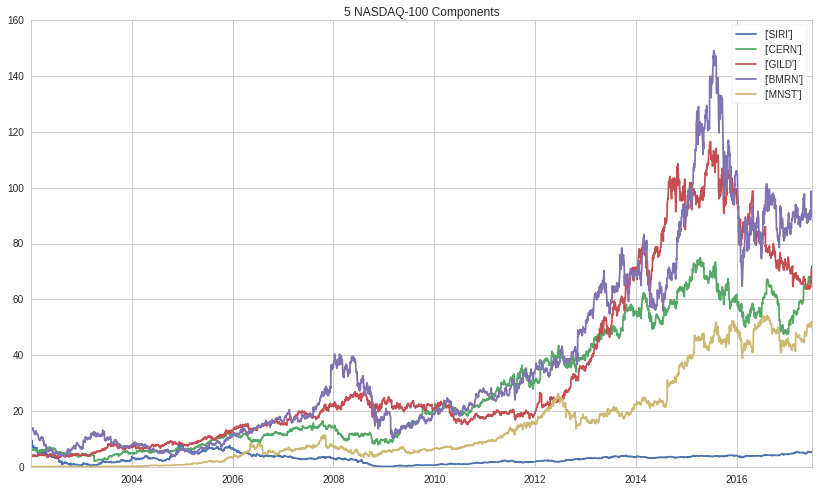

In [144]:
symbols = np.random.randint(low = 0, high = len(symbol_list), size = 5)
names = [[symbol_list[symbols[x]]] for x in range(len(symbols))]
plt.plot(prices_df[symbols])
plt.legend(names)
plt.title("5 NASDAQ-100 Components");

In [145]:
def get_returns(data):
# This function will get the daily multiplicative returns from 12 months ago till 2 months ago for a 
# list of assets
# Create data frame for T-12 to T-2 percentage returns
    returns = pd.DataFrame(columns=symbol_list, index=range(len(data)-360))
# Go through each asset one at a time
    for ticker in symbol_list:
# For each asset, go through each day one at a time
        for i in range(360,len(data)):
# On each day, find the returns of the asset from 12 months ago till 2 months ago
            returns[str(ticker)][i-360] = (prices_df[str(ticker)][i-360] - prices_df[str(ticker)][i-60])/prices_df[str(ticker)][i-60]
    return returns

def get_top10(values):
# Get top 10th percentile of all returns list for a specific month
    asc = sorted(values, key=float, reverse=True)
    n = len(values)//10
    return (asc[0:n])

def get_bottom10(values):
# Get bottom 10th percentile of all returns list for a specific month
    desc = sorted(values, key=float)
    n = len(values)//10
    return (desc[0:n])

def get_WL(returns):
# Get the Momentum Value for each month (30 days), winners returns minus losers returns 
    timeind = [x*30 for x in range(len(year2month_returns)//30)]
    array = [0 for x in range(len(symbol_list))]
    monthly_momentum_list = [0 for x in range(len(timeind))]
    for month in timeind:
        for d in range(len(symbol_list)):
            array[d] = returns[symbol_list[d]][month]
            momentum = sum(get_top10(array)) - sum(get_bottom10(array))
            monthly_momentum_list[month/30] = momentum
    return monthly_momentum_list

def get_WinnersNames(returns):
# Get the Names of Winners and Losers (as lists) for each month 
    timeind = [x*30 for x in range(len(year2month_returns)//30)]
    array = [0 for x in range(len(symbol_list))]
    month_top_list = [0 for x in range(len(timeind))]
    for month in timeind:
        for d in range(len(symbol_list)):
            array[d] = returns[symbol_list[d]][month]
        topnames = ['' for x in range(7)]
        for a in range(7):
            for i in range(len(array)):
                if array[i] == max(array):
                    topnames[a] = symbol_list[i]
                    array[i] = np.median(array)
        month_top_list[month/30] = topnames
    return month_top_list

def get_LosersNames(returns):
# Get the Names of Losers (as lists) for each month 
    timeind = [x*30 for x in range(len(year2month_returns)//30)]
    array = [0 for x in range(len(symbol_list))]
    month_bottom_list = [0 for x in range(len(timeind))]
    for month in timeind:
        for d in range(len(symbol_list)):
            array[d] = returns[symbol_list[d]][month]
        bottomnames = ['' for x in range(7)]
        for a in range(7):
            for i in range(len(array)):
                if array[i] == min(array):
                    bottomnames[a] = symbol_list[i]
                    array[i] = np.median(array)
        month_bottom_list[month/30] = bottomnames
    return month_bottom_list

Get the returns from 12 months ago till 2 months ago, for every company in symbol list, for every day.

In [146]:
year2month_returns = get_returns(prices_df)

Find the top decile returns - bottom decile returns in the past month.

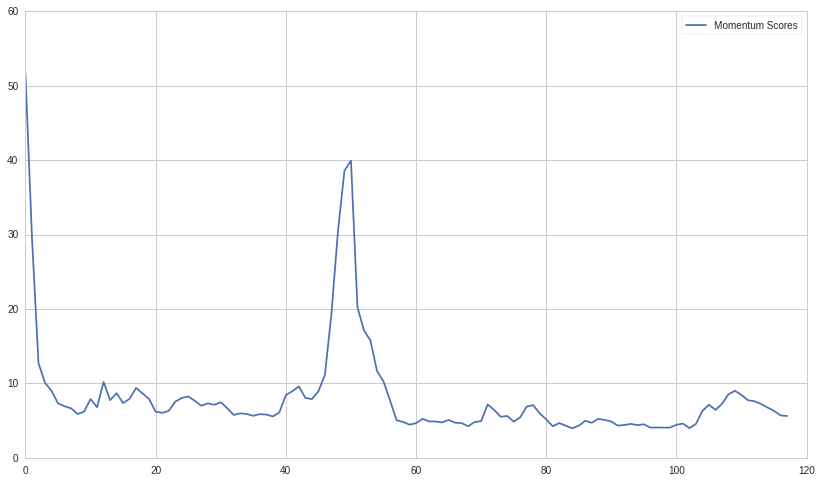

In [147]:
vector = get_WL(year2month_returns)
plt.plot(vector)
plt.legend(["Momentum Scores"]);

These Momentum values represent how much the 'winners' returns exceeded the 'losers' returns in the past. Since we have defined the winners and losers based on high and low ranking returns, these values should always be positive. However, we will soon take the forward 1-month returns of the winner and loser portfolio. We go long the winners and short the losers for 1 day, and update our lists.

In [148]:
# Here are the winners and losers for the first timepoint, 360 days after 2002-01-02 (the start of the dataset)
print str(get_WinnersNames(year2month_returns)[0]) + " are the first month's winners"
print str(get_LosersNames(year2month_returns)[0]) + " are the first month's losers"

['SIRI', 'INCY', 'PCLN', 'SWKS', 'CHKP', 'VRTX', 'SHPG'] are the first month's winners
['NTES', 'TSCO', 'SYMC', 'IDXX', 'WDC', 'JBHT', 'MYL'] are the first month's losers


In [149]:
def get_WMLresults(names, data, timepoint):
# Find the resulting returns in a 1-month forward investment long in winners, short in losers
# If our data starts at Day 0, this function should run from Day 360 till Day -30 (the 30th final day)
    winners = names[0]
    losers = names[1]
    winner_returns = 0
    loser_returns = 0
    i = timepoint 
# For each winner, find the future price in 1 month - today's value and divide by today's value to find
# the percent change in the next month
    for ticker in winners:
        f_val = data[ticker][(i+1)*30]
        p_val = data[ticker][i*30]
        winner_returns += ((f_val - p_val) / p_val)
# For each loser, find the future price in 1 month - today's value and divide by today's value to find
# the percent change in the next month
    for ticker in losers:
        f_val = data[ticker][(i+1)*30]
        p_val = data[ticker][i*30]
        winner_returns += ((f_val - p_val) / p_val)
# WML returns each month equal the difference between winner returns and loser returns
    returns = winner_returns - loser_returns       
    return returns
def get_momentumreturns(data):
# Find the returns of WML for each month 
    results = [0 for x in range(12,(len(data)//30)-1)]
# For each month, starting at Month 12 (Day 360) and ending at Month -1 (Day -30)
    for i in range(12, (len(data)//30)-1):
# Find the names of the winners and losers at the start of the month
        winlosenames = [get_WinnersNames(year2month_returns)[i-12],get_LosersNames(year2month_returns)[i-12]]
# Calculate how the long winners and short losers will perform in the next month
        results[i-12] = get_WMLresults(winlosenames,data,i)
    return results

In [150]:
# Calculate the returns of long winners and short losers each month over the time frame
results = get_momentumreturns(prices_df)

Here are the percentage returns from long winners and short losers each month. After this, we will see how managing risk can affect the strategy's performance. 
 - "Managing the risk of momentum leads to substantial economic gains. We simply scale the long-short portfolio by its realized volatility in the previous six months, targeting a strategy with constant volatility."

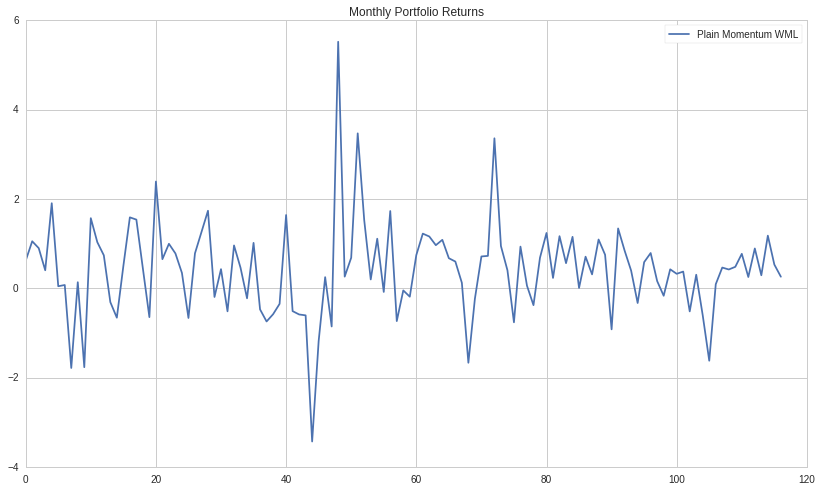

In [151]:
plt.plot(results);
plt.legend(["Plain Momentum WML"]);
plt.title("Monthly Portfolio Returns");

In [152]:
def find_previousvar(names, data, timepoint):
# Find the WML portfolio volatility in previous 6 months so we can forecast our risk
    winners = names[0]
    losers = names[1]
    i = timepoint 
    annualized_long_vol = [0 for x in range(len(winners))]
    annualized_short_vol = [0 for x in range(len(losers))]

# For each 'winner' asset
    count = 0
    for ticker in winners:
# Get the standard deviation of the asset's returns
        daily = data[ticker].pct_change()[(i-5):i].std()
# Annualize the volatility of returns
        annualized_long_vol[count] = daily * math.sqrt(252) * 100
        count += 1 
        
# For each 'loser' asset
    count = 0
    for ticker in losers:
# Get the standard deviation of the asset's returns
        daily = data[ticker].pct_change()[(i-11):i].std()
# Annualize the volatility of returns
        annualized_short_vol[count] = daily * math.sqrt(252) * 100
        count += 1
    
    total_vol = (np.mean(annualized_long_vol) + np.mean(annualized_short_vol)) / 2
    return total_vol

In [153]:
def calc_volatility(data):
# Calculate the past 6-month volatility for the portflio every month
    results = [0 for x in range(12,(len(data)//30)-1)]
# For each month, starting at Month 12 (Day 360) and ending at Month -1 (Day -30)
    for i in range(12, (len(data)//30)-1):
# Find the names of the winners and losers at the start of the month
        winlosenames = [get_WinnersNames(year2month_returns)[i-12],get_LosersNames(year2month_returns)[i-12]]
# Calculate how the long winners and short losers will perform in the next month
        results[i-12] = find_previousvar(winlosenames,data,i)
    return results

In [154]:
# Find the past 6 month volatility for the portfolio starting at Month 12 ending at Month -1
volatility_list = calc_volatility(prices_df)

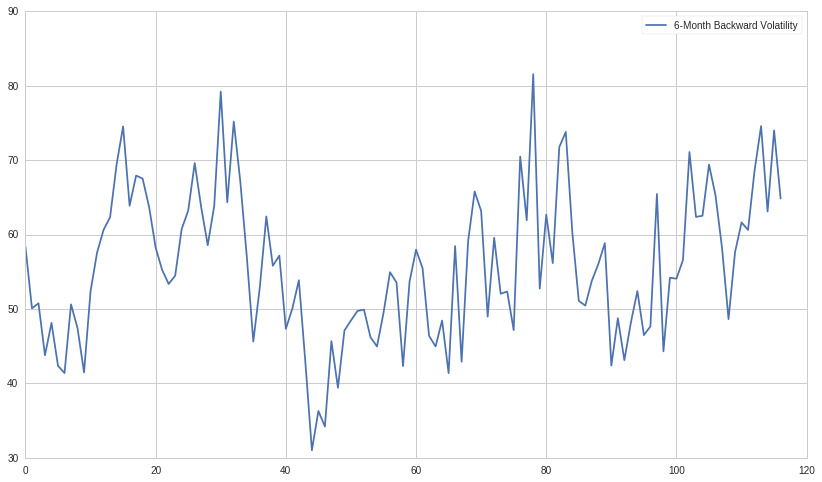

In [155]:
plt.plot(volatility_list)
plt.legend(["6-Month Backward Volatility"]);

The graph above shows the volatility of the WML portfolio (adjusted every month). The volatility is generally high, spanning from 30 - 80% annualized volatility, compared to SPX's volatility with a mean of 7.5%. By adjusting our strategy's leverage to account for this volatility forecast, we can mitigate our exposure during high volatility environments.

We will adjust our returns from the plain momentum strategy by leveraging the returns according to our 'target volatilty:realized volatility' ratio.

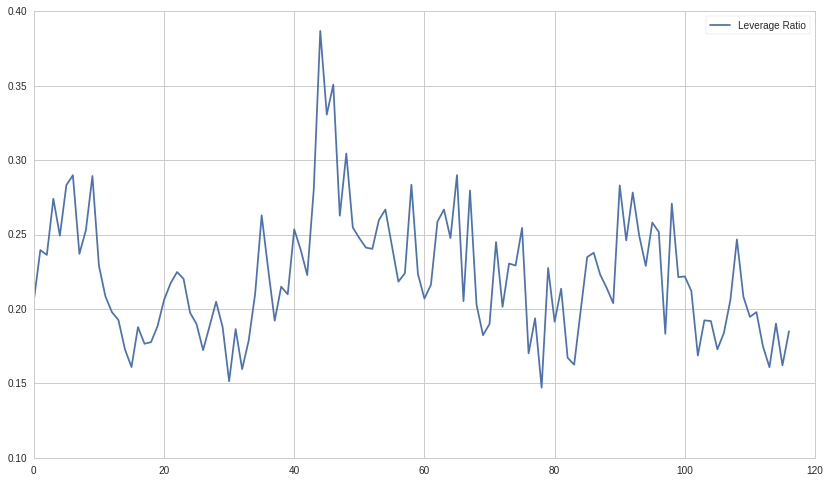

In [156]:
# Target volatility is 12% annualized
target_vol = 12
ratios = [(target_vol/volatility_list[i]) for i in range(len(volatility_list))]
plt.plot(ratios)
plt.legend(["Leverage Ratio"]);

Recall that the variable 'results' held the returns of the Plain Momentum WML strategy. Here is the orginal performance compared to the volatility-adjusted version.

In [157]:
adjusted_returns = [(results[i]*ratios[i]) for i in range(len(results))]

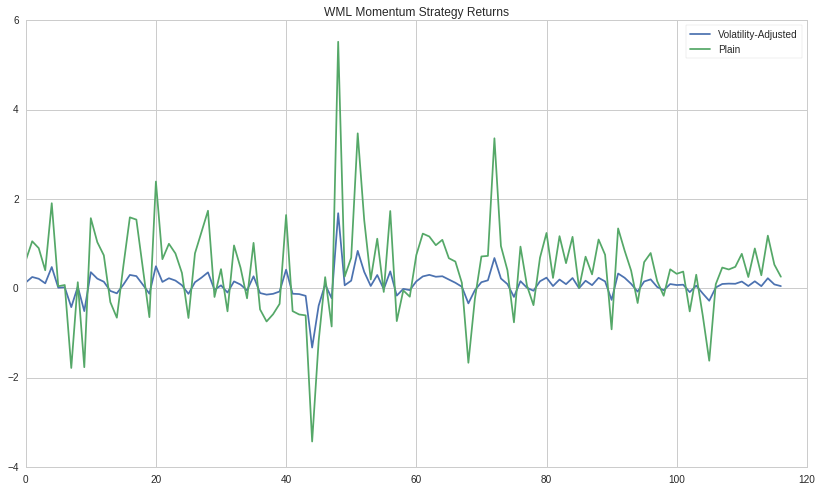

In [158]:
plt.plot(adjusted_returns)
plt.plot(results)
plt.legend(["Volatility-Adjusted", "Plain"])
plt.title("WML Momentum Strategy Returns");

The risk-adjusted strategy is greatly deleveraged compared to its plain counterpart. The risk adjustments allow the strategy to delever prior during high volatility environments, which reduces downside risk. While this deleveraging comes at the cost of reduced upside, the adjustment comes at an efficient risk/reward ratio to improve other portfolio metrics like Volatility, Sharpe Ratio, and (Reduced) Beta.